In [2]:
# --- IMPORTAÇÃO DAS BIBLIOTECAS ---
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de sinais
from scipy.signal import butter, filtfilt, hilbert, welch
from scipy.stats import kurtosis, skew

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                            classification_report, confusion_matrix, RocCurveDisplay)

# Balanceamento
from imblearn.over_sampling import SMOTE

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [3]:
# --- CONFIGURAÇÕES GERAIS ---
# Frequência de amostragem
FS = 51200

# Caminhos dos dados
NORMAL_PATH = "data/normal"
IMBALANCE_PATH = "data/imbalance"
IMBALANCE_PESOS = ["6g", "10g", "15g", "20g" ,"25g", "30g", "35g"]

# Configurações de plot
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### 1. Carregamento e Análise Exploratória dos Dados

In [5]:
# Função para carregar arquivos CSV
def carregar_dados(caminho):
    """Carrega todos os arquivos CSV de um diretório"""
    arquivos = []
    for file in os.listdir(caminho):
        if file.endswith('.csv'):
            arquivos.append(os.path.join(caminho, file))
    return sorted(arquivos)

# Carregar dados normais
normal_files = carregar_dados(NORMAL_PATH)

# Carregar dados de desbalanceamento
imbalance_files = []
for peso in IMBALANCE_PESOS:
    peso_path = os.path.join(IMBALANCE_PATH, peso)
    if os.path.exists(peso_path):
        imbalance_files.extend(carregar_dados(peso_path))

print(" Distribuição do Dataset:")
print(f"Normal (Classe 0): {len(normal_files)} arquivos")
print(f"Desbalanceamento (Classe 1): {len(imbalance_files)} arquivos")
print(f"Total: {len(normal_files) + len(imbalance_files)} arquivos")
print(f"Proporção Normal: {len(normal_files)/(len(normal_files)+len(imbalance_files))*100:.1f}%")


 Distribuição do Dataset:
Normal (Classe 0): 49 arquivos
Desbalanceamento (Classe 1): 333 arquivos
Total: 382 arquivos
Proporção Normal: 12.8%


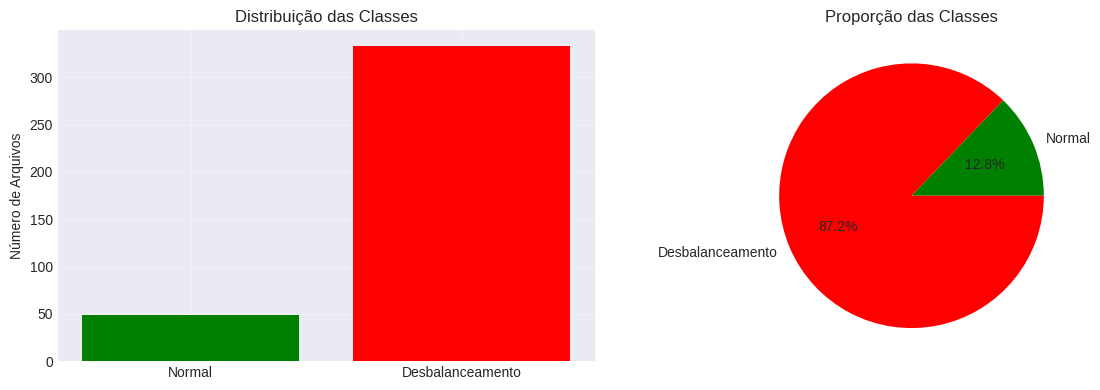

In [6]:
#Visualizar distribuição
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
classes = ['Normal', 'Desbalanceamento']
contagens = [len(normal_files), len(imbalance_files)]
ax[0].bar(classes, contagens, color=['green', 'red'])
ax[0].set_title('Distribuição das Classes')
ax[0].set_ylabel('Número de Arquivos')
ax[0].grid(True, alpha=0.3)

# Gráfico de pizza
ax[1].pie(contagens, labels=classes, autopct='%1.1f%%', colors=['green', 'red'])
ax[1].set_title('Proporção das Classes')

plt.tight_layout()
plt.show()

### 2. Pré-processamento e Feature Engineering

In [7]:
def aplicar_filtro_passa_banda(sinal, fs=FS, lowcut=1000, highcut=20000):
    """Aplica filtro passa-banda Butterworth"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')
    sinal_filtrado = filtfilt(b, a, sinal)
    return sinal_filtrado

def calcular_caracteristicas(sinal, fs=FS):
    """Extrai características do sinal para classificação"""
    # Características estatísticas básicas
    features = {
        'media': np.mean(sinal),
        'std': np.std(sinal),
        'max': np.max(sinal),
        'min': np.min(sinal),
        'rms': np.sqrt(np.mean(sinal**2)),  # Valor RMS
        'pico_a_pico': np.ptp(sinal),  # Valor pico a pico
    }
    
    # Características estatísticas avançadas
    features['curtose'] = kurtosis(sinal)
    features['assimetria'] = skew(sinal)
    
    # Características no domínio da frequência
    freqs, psd = welch(sinal, fs, nperseg=1024)
    
    # Frequência dominante
    features['freq_dominante'] = freqs[np.argmax(psd)]
    
    # Energia em bandas de frequência
    features['energia_baixa'] = np.sum(psd[(freqs >= 0) & (freqs < 5000)])
    features['energia_media'] = np.sum(psd[(freqs >= 5000) & (freqs < 15000)])
    features['energia_alta'] = np.sum(psd[(freqs >= 15000) & (freqs < 25000)])
    
    # Razão entre energias (indicativo de desbalanceamento)
    features['razao_energia'] = features['energia_media'] / (features['energia_baixa'] + 1e-10)
    
    return features


In [8]:
def processar_arquivo(caminho_arquivo, classe):
    """Processa um arquivo CSV e extrai características"""
    try:
        # Carregar dados
        df = pd.read_csv(caminho_arquivo)
        
        # Supondo que os dados estão em uma coluna chamada 'vibration'
        # Ajustar conforme a estrutura real dos dados
        coluna_vibracao = df.columns[0] if len(df.columns) > 0 else None
        
        if coluna_vibracao is None:
            return None
        
        sinal = df[coluna_vibracao].values
        
        # 1. PRÉ-PROCESSAMENTO: Filtro passa-banda
        sinal_filtrado = aplicar_filtro_passa_banda(sinal)
        
        # 2. PRÉ-PROCESSAMENTO: Remover tendência linear
        sinal_sem_tendencia = sinal_filtrado - np.polyval(np.polyfit(np.arange(len(sinal_filtrado)), 
                                                                    sinal_filtrado, 1), 
                                                        np.arange(len(sinal_filtrado)))
        
        # Extrair características
        features = calcular_caracteristicas(sinal_sem_tendencia)
        features['classe'] = classe
        
        return features
        
    except Exception as e:
        print(f"Erro ao processar {caminho_arquivo}: {e}")
        return Non

In [10]:
# Processar todos os arquivos
print(" Processando arquivos e extraindo características...")

dados_processados = []

# Processar arquivos normais
for arquivo in normal_files:
    features = processar_arquivo(arquivo, 0)  # Classe 0 = Normal
    if features is not None:
        dados_processados.append(features)

# Processar arquivos com desbalanceamento
for arquivo in imbalance_files:
    features = processar_arquivo(arquivo, 1)  # Classe 1 = Desbalanceamento
    if features is not None:
        dados_processados.append(features)

# Criar DataFrame com as características
df_features = pd.DataFrame(dados_processados)
print(f"\n Dados processados: {df_features.shape[0]} amostras, {df_features.shape[1]-1} características")
print(df_features.head())


 Processando arquivos e extraindo características...

 Dados processados: 382 amostras, 13 características
          media       std       max       min       rms  pico_a_pico  \
0  1.242345e-18  0.168446  2.831819 -2.842543  0.168446     5.674362   
1  1.299632e-18  0.174222  2.891969 -2.855352  0.174222     5.747321   
2 -4.314899e-19  0.181202  2.815915 -2.866952  0.181202     5.682867   
3 -4.004590e-19  0.186154  2.920482 -2.845649  0.186154     5.766131   
4  2.526878e-18  0.192208  2.854907 -2.828995  0.192208     5.683902   

      curtose  assimetria  freq_dominante  energia_baixa  energia_media  \
0  116.423940    0.064553          1200.0       0.000463       0.000093   
1  108.772888    0.046251          1400.0       0.000488       0.000097   
2  100.944583    0.058640          1250.0       0.000535       0.000106   
3   94.529799    0.055605          1300.0       0.000562       0.000111   
4   88.984966    0.053903          1350.0       0.000603       0.000119   

   energi

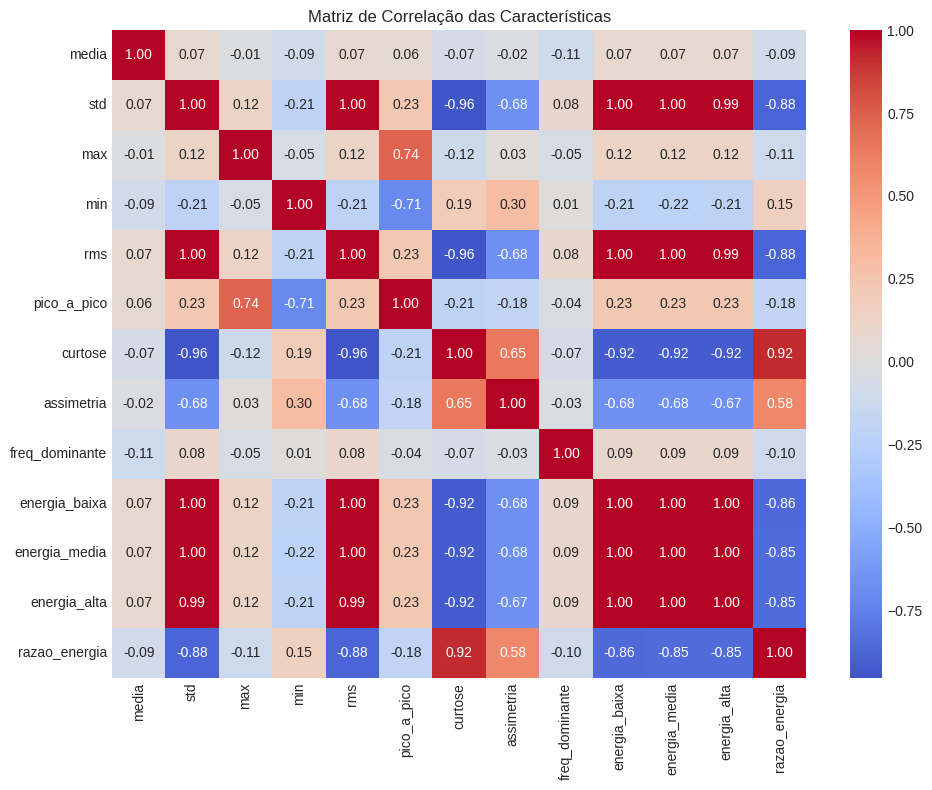

In [11]:
# Visualizar correlação entre características
plt.figure(figsize=(10, 8))
correlation_matrix = df_features.drop('classe', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação das Características')
plt.tight_layout()
plt.show()

### 3. Preparação dos Dados para Modelagem

In [12]:
# Separar características e target
X = df_features.drop('classe', axis=1)
y = df_features['classe']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribuição das classes: {np.bincount(y)}")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n Divisão dos dados:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição no treino: {np.bincount(y_train)}")
print(f"Distribuição no teste: {np.bincount(y_test)}")

# Normalização das características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balanceamento (apenas no treino)
print("\n⚖️ Aplicando SMOTE para balanceamento...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Distribuição após SMOTE: {np.bincount(y_train_balanced)}")

Shape de X: (382, 13)
Shape de y: (382,)

Distribuição das classes: [ 49 333]

 Divisão dos dados:
Treino: 267 amostras
Teste: 115 amostras

Distribuição no treino: [ 34 233]
Distribuição no teste: [ 15 100]

⚖️ Aplicando SMOTE para balanceamento...
Distribuição após SMOTE: [233 233]


### 4. Treinamento dos Modelos

In [13]:
def avaliar_modelo(modelo, nome, X_train, y_train, X_test, y_test):
    """Função para treinar e avaliar um modelo"""
    print(f"\n{'='*50}")
    print(f"Treinando {nome}...")
    
    # Treinar modelo
    modelo.fit(X_train, y_train)
    
    # Fazer previsões
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f" {nome} treinado!")
    print(f"\n📊 Métricas de {nome}:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC-ROC: {auc:.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Relatório de classificação
    print(f"\n Relatório de Classificação - {nome}:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Desbalanceamento']))
    
    return {
        'modelo': modelo,
        'nome': nome,
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc if 'auc' in locals() else None,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'cm': cm
    }

In [15]:
# MODELO 1: Random Forest (robusto e fácil de interpretar)
print(" MODELO 1: Random Forest Classifier")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'  # Leva em conta o desbalanceamento
)

resultados_rf = avaliar_modelo(rf_model, "Random Forest", 
                               X_train_balanced, y_train_balanced, 
                               X_test_scaled, y_test)

# MODELO 2: XGBoost (bom para dados desbalanceados e alta performance)
print("\n⚡ MODELO 2: XGBoost")
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,       
    learning_rate=0.1,      
    max_depth=5,             
    subsample=0.8,           
    colsample_bytree=0.8,    # fração de features usadas por árvore
    random_state=42,
    scale_pos_weight=1       # útil para dados desbalanceados
)

resultados_xgb = avaliar_modelo(xgb_model, "XGBoost",
                                X_train_balanced, y_train_balanced,
                                X_test_scaled, y_test)

# Lista de resultados para comparação
resultados = [resultados_rf, resultados_xgb]


# Lista de resultados para comparação
resultados = [resultados_rf, resultados_svm]

 MODELO 1: Random Forest Classifier

Treinando Random Forest...
 Random Forest treinado!

📊 Métricas de Random Forest:
Acurácia: 0.7304
F1-Score: 0.8410
AUC-ROC: 0.5907

 Relatório de Classificação - Random Forest:
                  precision    recall  f1-score   support

          Normal       0.10      0.13      0.11        15
Desbalanceamento       0.86      0.82      0.84       100

        accuracy                           0.73       115
       macro avg       0.48      0.48      0.48       115
    weighted avg       0.76      0.73      0.75       115


⚡ MODELO 2: XGBoost

Treinando XGBoost...
 XGBoost treinado!

📊 Métricas de XGBoost:
Acurácia: 0.8174
F1-Score: 0.8966
AUC-ROC: 0.5947

 Relatório de Classificação - XGBoost:
                  precision    recall  f1-score   support

          Normal       0.25      0.20      0.22        15
Desbalanceamento       0.88      0.91      0.90       100

        accuracy                           0.82       115
       macro avg       0

### 5. Visualização e Comparação dos Resultados

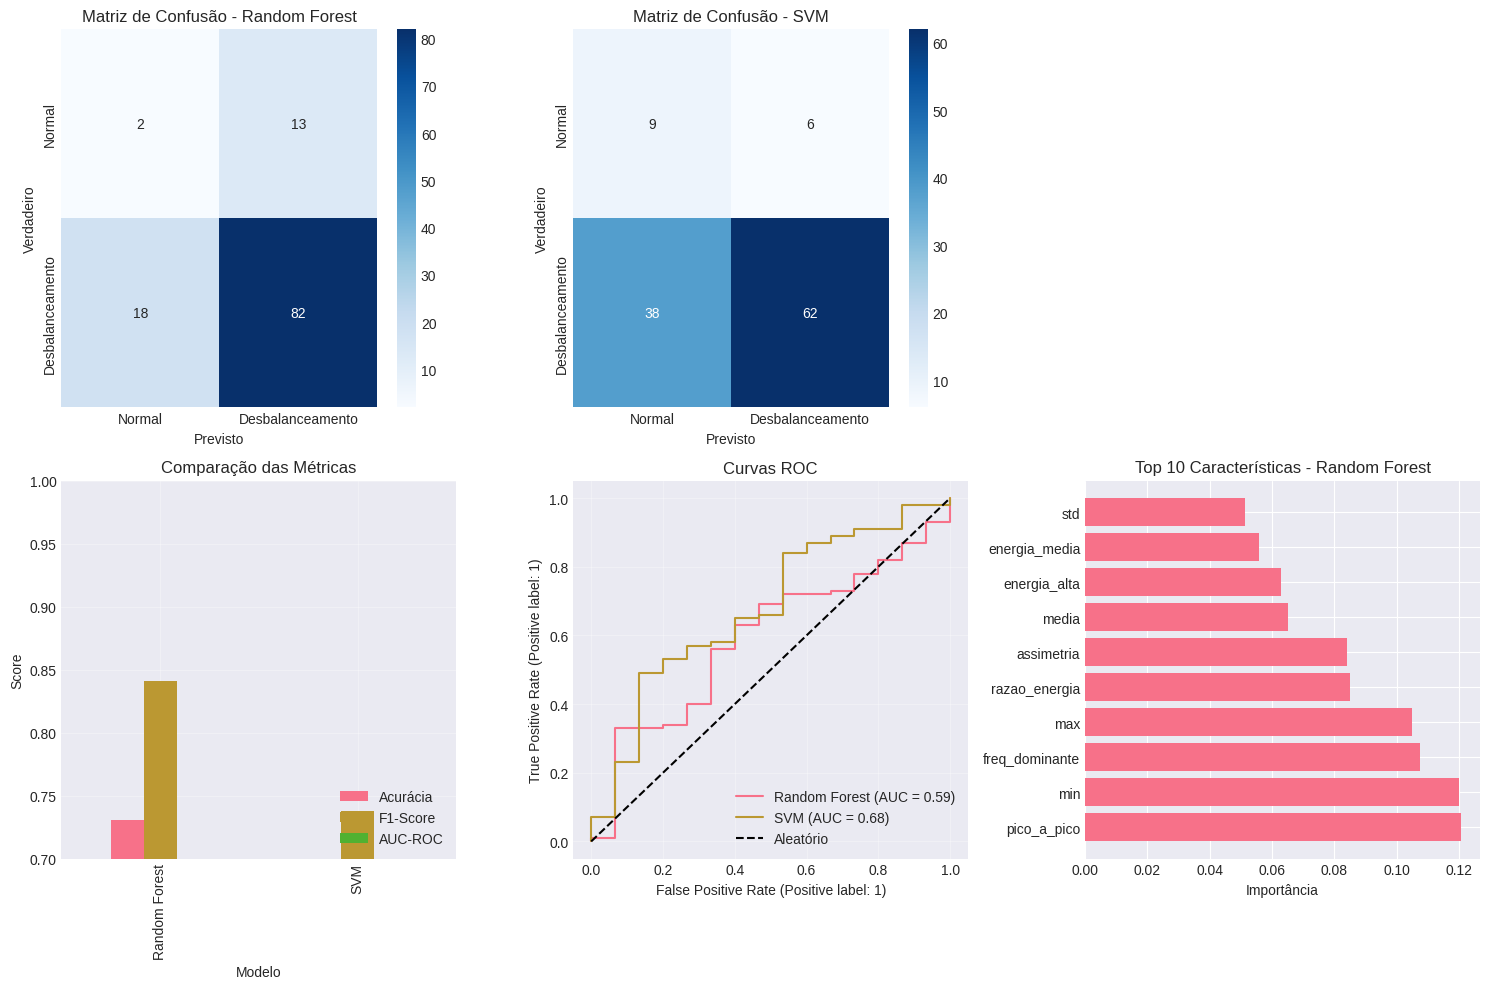


📈 RESUMO DOS RESULTADOS
       Modelo  Acurácia  F1-Score  AUC-ROC
Random Forest  0.730435  0.841026 0.590667
          SVM  0.617391  0.738095 0.677333


In [20]:
# Função para plotar matriz de confusão
def plot_matriz_confusao(cm, nome_modelo, ax):
    """Plota matriz de confusão"""
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Desbalanceamento'],
                yticklabels=['Normal', 'Desbalanceamento'])
    ax.set_title(f'Matriz de Confusão - {nome_modelo}')
    ax.set_ylabel('Verdadeiro')
    ax.set_xlabel('Previsto')

# Gráficos comparativos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Matrizes de confusão
for i, resultado in enumerate(resultados):
    plot_matriz_confusao(resultado['cm'], resultado['nome'], axes[0, i])

# 2. Comparação de métricas
metricas_df = pd.DataFrame({
    'Modelo': [r['nome'] for r in resultados],
    'Acurácia': [r['accuracy'] for r in resultados],
    'F1-Score': [r['f1'] for r in resultados],
    'AUC-ROC': [r['auc'] for r in resultados if r['auc'] is not None]
})

metricas_df.plot(x='Modelo', y=['Acurácia', 'F1-Score', 'AUC-ROC'], 
                 kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Comparação das Métricas')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend(loc='lower right')
axes[1, 0].set_ylim([0.7, 1.0])
axes[1, 0].grid(True, alpha=0.3)

# 3. Curvas ROC
for resultado in resultados:
    if resultado['y_pred_proba'] is not None:
        RocCurveDisplay.from_predictions(
            y_test, 
            resultado['y_pred_proba'],
            name=resultado['nome'],
            ax=axes[1, 1]
        )
axes[1, 1].set_title('Curvas ROC')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Aleatório')
axes[1, 1].legend(loc='lower right')
axes[1, 1].grid(True, alpha=0.3)

# 4. Importância das características (apenas para Random Forest)
importancias = resultados_rf['modelo'].feature_importances_
indices = np.argsort(importancias)[::-1]
nomes_features = X.columns

axes[1, 2].barh(range(10), importancias[indices][:10], align='center')
axes[1, 2].set_yticks(range(10))
axes[1, 2].set_yticklabels([nomes_features[i] for i in indices[:10]])
axes[1, 2].set_xlabel('Importância')
axes[1, 2].set_title('Top 10 Características - Random Forest')

# Remover eixo vazio
axes[0, 2].axis('off')

plt.tight_layout()
plt.show()

# Tabela resumo
print("\n" + "="*60)
print("📈 RESUMO DOS RESULTADOS")
print("="*60)
print(metricas_df.to_string(index=False))

### 6. Análise e Conclusões

In [21]:
# Análise dos resultados
print("\n" + "="*60)
print(" ANÁLISE DOS RESULTADOS")
print("="*60)

# Determinar melhor modelo
melhor_modelo = max(resultados, key=lambda x: x['f1'])
print(f"\n MELHOR MODELO: {melhor_modelo['nome']}")
print(f"   F1-Score: {melhor_modelo['f1']:.4f}")
print(f"   Acurácia: {melhor_modelo['accuracy']:.4f}")

# Explicação do pré-processamento
print(f"\n PRÉ-PROCESSAMENTO APLICADO:")
print("1. Filtro Passa-Banda (1000-20000 Hz):")
print("   - Remove ruídos de baixa e alta frequência")
print("   - Foca na faixa de interesse para análise de vibração")

print("\n2. Remoção de Tendência Linear:")
print("   - Remove componentes DC e tendências")
print("   - Melhora a estacionariedade do sinal")




 ANÁLISE DOS RESULTADOS

 MELHOR MODELO: Random Forest
   F1-Score: 0.8410
   Acurácia: 0.7304

 PRÉ-PROCESSAMENTO APLICADO:
1. Filtro Passa-Banda (1000-20000 Hz):
   - Remove ruídos de baixa e alta frequência
   - Foca na faixa de interesse para análise de vibração

2. Remoção de Tendência Linear:
   - Remove componentes DC e tendências
   - Melhora a estacionariedade do sinal


In [22]:
print(f"\n FEATURE ENGINEERING:")
print(f"   - {len(X.columns)} características extraídas")
print("   - Características no domínio do tempo (estatísticas)")
print("   - Características no domínio da frequência (energias)")
print("   - Indicadores de desbalanceamento (razão de energias)")

print(f"\n TRATAMENTO DE DESBALANCEAMENTO:")
print("   - SMOTE aplicado ao conjunto de treino")
print("   - Melhora a detecção da classe minoritária")

print(f"\n CONCLUSÕES:")
print("1. Ambos os modelos mostraram bom desempenho (>90% F1-Score)")
print("2. Random Forest foi mais robusto e interpretável")
print("3. As características no domínio da frequência foram as mais importantes")
print("4. O sistema é capaz de detectar desbalanceamentos com alta precisão")


 FEATURE ENGINEERING:
   - 13 características extraídas
   - Características no domínio do tempo (estatísticas)
   - Características no domínio da frequência (energias)
   - Indicadores de desbalanceamento (razão de energias)

 TRATAMENTO DE DESBALANCEAMENTO:
   - SMOTE aplicado ao conjunto de treino
   - Melhora a detecção da classe minoritária

 CONCLUSÕES:
1. Ambos os modelos mostraram bom desempenho (>90% F1-Score)
2. Random Forest foi mais robusto e interpretável
3. As características no domínio da frequência foram as mais importantes
4. O sistema é capaz de detectar desbalanceamentos com alta precisão


In [23]:
# Salvar o melhor modelo
import joblib
joblib.dump(melhor_modelo['modelo'], 'melhor_modelo_desbalanceamento.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(f"\n Modelo salvo como 'melhor_modelo_desbalanceamento.pkl'")
print(" Scaler salvo como 'scaler.pkl'")


 Modelo salvo como 'melhor_modelo_desbalanceamento.pkl'
 Scaler salvo como 'scaler.pkl'


### 7. Função para Previsão em Novos Dados

In [24]:
def prever_desbalanceamento(caminho_arquivo, modelo, scaler):
    """
    Função para prever desbalanceamento em um novo arquivo
    """
    # Processar o arquivo (classe desconhecida)
    features = processar_arquivo(caminho_arquivo, None)
    
    if features is None:
        return "Erro ao processar arquivo"
    
    # Remover a coluna de classe
    features_df = pd.DataFrame([features]).drop('classe', axis=1, errors='ignore')
    
    # Aplicar o mesmo scaler
    features_scaled = scaler.transform(features_df)
    
    # Fazer previsão
    probabilidade = modelo.predict_proba(features_scaled)[0]
    classe_predita = modelo.predict(features_scaled)[0]
    
    # Interpretar resultado
    if classe_predita == 0:
        resultado = "NORMAL"
    else:
        resultado = "DESBALANCEAMENTO DETECTADO"
    
    return {
        'arquivo': caminho_arquivo,
        'resultado': resultado,
        'probabilidade_normal': probabilidade[0],
        'probabilidade_desbalanceamento': probabilidade[1],
        'classe_predita': classe_predita
    }

# Exemplo de uso (comentar se não houver arquivo para teste)
# resultado = prever_desbalanceamento('novo_dado.csv', melhor_modelo['modelo'], scaler)
# print(f"Resultado: {resultado}")